In [1]:
%matplotlib inline


Link Prediction using Graph Neural Networks
===========================================

In the :doc:`introduction <1_introduction>`, you have already learned
the basic workflow of using GNNs for node classification,
i.e. predicting the category of a node in a graph. This tutorial will
teach you how to train a GNN for link prediction, i.e. predicting the
existence of an edge between two arbitrary nodes in a graph.

By the end of this tutorial you will be able to

-  Build a GNN-based link prediction model.
-  Train and evaluate the model on a small DGL-provided dataset.

(Time estimate: 28 minutes)


In [2]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp

import matplotlib.pyplot as plt
import networkx as nx

import os

Overview of Link Prediction with GNN
------------------------------------

Many applications such as social recommendation, item recommendation,
knowledge graph completion, etc., can be formulated as link prediction,
which predicts whether an edge exists between two particular nodes. This
tutorial shows an example of predicting whether a citation relationship,
either citing or being cited, between two papers exists in a citation
network.

This tutorial formulates the link prediction problem as a binary classification
problem as follows:

-  Treat the edges in the graph as *positive examples*.
-  Sample a number of non-existent edges (i.e. node pairs with no edges
   between them) as *negative* examples.
-  Divide the positive examples and negative examples into a training
   set and a test set.
-  Evaluate the model with any binary classification metric such as Area
   Under Curve (AUC).

<div class="alert alert-info"><h4>Note</h4><p>The practice comes from
   `SEAL <https://papers.nips.cc/paper/2018/file/53f0d7c537d99b3824f0f99d62ea2428-Paper.pdf>`__,
   although the model here does not use their idea of node labeling.</p></div>

In some domains such as large-scale recommender systems or information
retrieval, you may favor metrics that emphasize good performance of
top-K predictions. In these cases you may want to consider other metrics
such as mean average precision, and use other negative sampling methods,
which are beyond the scope of this tutorial.

Loading graph and features
--------------------------

Following the :doc:`introduction <1_introduction>`, this tutorial
first loads the Cora dataset.




In [3]:
import helpers


library = "stdlib"

print("Loading network and entries for", library)
entries, network = helpers.load_library(library)
raw2label, label2raw = helpers.create_dictionaries(library)

Loading network and entries for stdlib
Loading entries ...


  0%|          | 0/16483 [00:00<?, ?it/s]

100%|██████████| 16483/16483 [03:16<00:00, 83.74it/s] 


Loaded 16483 entries.
Loading network ...
Loaded G(V, E) where (|V|, |E|) = (16855, 242484)
Creating dictionaries for stdlib...


In [4]:
# One Hot Encoding

node_labels_counter = {}
for data in network.nodes.data():
    label = data[1]["label"]
    if label in node_labels_counter:
        node_labels_counter[label] += 1
    else:
        node_labels_counter[label] = 1

node_labels_list = list(node_labels_counter.keys())

for node in network.nodes:
    label = network.nodes[node]["label"]
    network.nodes[node]["encoded label"] = [float(item == label) for item in node_labels_list]

In [5]:
edge_labels_counter = {}
for data in network.edges:
    label = data[2]
    if label in edge_labels_counter:
        edge_labels_counter[label] += 1
    else:
        edge_labels_counter[label] = 1

edge_labels_list = list(edge_labels_counter.keys())

for edge in network.edges:
    label = edge[2]
    network.edges[edge]["encoded label"] = [float(item == label) for item in edge_labels_list]

In [6]:
edge_labels_counter

{'REFERENCE_BODY': 137040,
 'REFERENCE_TYPE': 88591,
 'CONTAINS': 380,
 'DEFINES': 16473}

In [7]:
# Add embeddings to labels
import random
import entries_extractor as ee
embedding_size = None
no_embedding = {}
# Reset
for node in network.nodes:
    if "embedding" in network.nodes[node]:
        del network.nodes[node]["embedding"]

with open(os.path.join("data", "embeddings", "code2class", f"{library}.tsv")) as f:
    f.readline()
    for line in f:
        parts = line.split("\t")
        label = parts[0]
        name = label2raw[label]
        network.nodes[name]["embedding"] = [float(x) for x in parts[1:]]
        if not embedding_size:
            embedding_size = len(parts[1:])
for node in network.nodes:
    if "embedding" not in network.nodes[node]:
        network.nodes[node]["embedding"] = [random.random() for i in range(embedding_size)]
        no_embedding[node] = helpers.replace_unicode_with_latex(node).replace("\\\\", "\\")
        
print("Nodes without embedding:")
for name, label in no_embedding.items():
    print(f"\t{name}: {label}")

Nodes without embedding:
	Agda.Builtin.Bool.Bool 6: Agda.Builtin.Bool.Bool 6
	Agda.Builtin.Bool.Bool.false 8: Agda.Builtin.Bool.Bool.false 8
	Agda.Builtin.Bool.Bool.true 10: Agda.Builtin.Bool.Bool.true 10
	Agda.Builtin.Char.Properties.primCharToNatInjective 12: Agda.Builtin.Char.Properties.primCharToNatInjective 12
	Agda.Builtin.Char.Char 6: Agda.Builtin.Char.Char 6
	Agda.Builtin.Char.primIsLower 8: Agda.Builtin.Char.primIsLower 8
	Agda.Builtin.Char.primIsAlpha 12: Agda.Builtin.Char.primIsAlpha 12
	Agda.Builtin.Char.primIsSpace 14: Agda.Builtin.Char.primIsSpace 14
	Agda.Builtin.Char.primIsLatin1 18: Agda.Builtin.Char.primIsLatin1 18
	Agda.Builtin.Char.primIsPrint 20: Agda.Builtin.Char.primIsPrint 20
	Agda.Builtin.Char.primToLower 26: Agda.Builtin.Char.primToLower 26
	Agda.Builtin.Char.primCharToNat 28: Agda.Builtin.Char.primCharToNat 28
	Agda.Builtin.Char.primCharEquality 32: Agda.Builtin.Char.primCharEquality 32
	Agda.Builtin.Coinduction.∞ 10: Agda.Builtin.Coinduction.\infty 10
	Agda.

In [9]:
len(no_embedding)

15101

In [ ]:
for key in label2raw.keys():
    if "Data.Sum.Algebra" in key:
        print(key)
label2raw["Data.Sum.Algebra._.\\uplus-assoc"]

Data.Sum.Algebra.\sharp
Data.Sum.Algebra.\uplus-cong
Data.Sum.Algebra.\uplus-comm
Data.Sum.Algebra._.\uplus-assoc
Data.Sum.Algebra._.\uplus-identity{^l}
Data.Sum.Algebra._.\uplus-identity{^r}
Data.Sum.Algebra._.\uplus-identity
Data.Sum.Algebra._.\uplus-isMagma
Data.Sum.Algebra._.\uplus-isSemigroup
Data.Sum.Algebra._.\uplus-isMonoid
Data.Sum.Algebra._.\uplus-isCommutativeMonoid
Data.Sum.Algebra._.\uplus-magma
Data.Sum.Algebra._.\uplus-semigroup
Data.Sum.Algebra._.\uplus-monoid
Data.Sum.Algebra._.\uplus-commutativeMonoid
Data.Sum.Algebra


'Data.Sum.Algebra._.⊎-assoc 226'

In [ ]:

g = dgl.from_networkx(network,node_attrs=["encoded label", "embedding"],edge_attrs=["encoded label"])

Prepare training and testing sets
---------------------------------

This tutorial randomly picks 10% of the edges for positive examples in
the test set, and leave the rest for the training set. It then samples
the same number of edges for negative examples in both sets.




In [ ]:
# Split edge set for training and testing
u, v = g.edges()

eids = np.arange(g.number_of_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.1)
train_size = g.number_of_edges() - test_size
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

# Find all negative edges and split them for training and testing
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())), shape=(g.number_of_nodes(), g.number_of_nodes()))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

neg_eids = np.random.choice(len(neg_u), g.number_of_edges())
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]

When training, you will need to remove the edges in the test set from
the original graph. You can do this via ``dgl.remove_edges``.

<div class="alert alert-info"><h4>Note</h4><p>``dgl.remove_edges`` works by creating a subgraph from the
   original graph, resulting in a copy and therefore could be slow for
   large graphs. If so, you could save the training and test graph to
   disk, as you would do for preprocessing.</p></div>




In [ ]:
train_g = dgl.remove_edges(g, eids[:test_size])

Define a GraphSAGE model
------------------------

This tutorial builds a model consisting of two
`GraphSAGE <https://arxiv.org/abs/1706.02216>`__ layers, each computes
new node representations by averaging neighbor information. DGL provides
``dgl.nn.SAGEConv`` that conveniently creates a GraphSAGE layer.




In [ ]:
from dgl.nn import SAGEConv

# ----------- 2. create model -------------- #
# build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')
    
    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

The model then predicts the probability of existence of an edge by
computing a score between the representations of both incident nodes
with a function (e.g. an MLP or a dot product), which you will see in
the next section.

\begin{align}\hat{y}_{u\sim v} = f(h_u, h_v)\end{align}




Positive graph, negative graph, and ``apply_edges``
---------------------------------------------------

In previous tutorials you have learned how to compute node
representations with a GNN. However, link prediction requires you to
compute representation of *pairs of nodes*.

DGL recommends you to treat the pairs of nodes as another graph, since
you can describe a pair of nodes with an edge. In link prediction, you
will have a *positive graph* consisting of all the positive examples as
edges, and a *negative graph* consisting of all the negative examples.
The *positive graph* and the *negative graph* will contain the same set
of nodes as the original graph.  This makes it easier to pass node
features among multiple graphs for computation.  As you will see later,
you can directly feed the node representations computed on the entire
graph to the positive and the negative graphs for computing pair-wise
scores.

The following code constructs the positive graph and the negative graph
for the training set and the test set respectively.




In [ ]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

The benefit of treating the pairs of nodes as a graph is that you can
use the ``DGLGraph.apply_edges`` method, which conveniently computes new
edge features based on the incident nodes’ features and the original
edge features (if applicable).

DGL provides a set of optimized builtin functions to compute new
edge features based on the original node/edge features. For example,
``dgl.function.u_dot_v`` computes a dot product of the incident nodes’
representations for each edge.




In [ ]:
import dgl.function as fn

class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

You can also write your own function if it is complex.
For instance, the following module produces a scalar score on each edge
by concatenating the incident nodes’ features and passing it to an MLP.




In [ ]:
class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        """
        Computes a scalar score for each edge of the given graph.

        Parameters
        ----------
        edges :
            Has three members ``src``, ``dst`` and ``data``, each of
            which is a dictionary representing the features of the
            source nodes, the destination nodes, and the edges
            themselves.

        Returns
        -------
        dict
            A dictionary of new edge features.
        """
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

<div class="alert alert-info"><h4>Note</h4><p>The builtin functions are optimized for both speed and memory.
   We recommend using builtin functions whenever possible.</p></div>

<div class="alert alert-info"><h4>Note</h4><p>If you have read the :doc:`message passing
   tutorial <3_message_passing>`, you will notice that the
   argument ``apply_edges`` takes has exactly the same form as a message
   function in ``update_all``.</p></div>




Training loop
-------------

After you defined the node representation computation and the edge score
computation, you can go ahead and define the overall model, loss
function, and evaluation metric.

The loss function is simply binary cross entropy loss.

\begin{align}\mathcal{L} = -\sum_{u\sim v\in \mathcal{D}}\left( y_{u\sim v}\log(\hat{y}_{u\sim v}) + (1-y_{u\sim v})\log(1-\hat{y}_{u\sim v})) \right)\end{align}

The evaluation metric in this tutorial is AUC.




In [ ]:
train_g.ndata['encoded label'].shape

torch.Size([16855, 12])

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

model = GraphSAGE(train_g.ndata['encoded label'].shape[1], 16)
# You can replace DotPredictor with MLPPredictor.
#pred = MLPPredictor(16)
pred = DotPredictor()

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

def plot_roc_curve(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    fpr, tpr, treshold = roc_curve(labels, scores)
    plt.plot(fpr, tpr)

The training loop goes as follows:

<div class="alert alert-info"><h4>Note</h4><p>This tutorial does not include evaluation on a validation
   set. In practice you should save and evaluate the best model based on
   performance on the validation set.</p></div>




In [ ]:
# ----------- 3. set up loss and optimizer -------------- #
# in this case, loss will in training loop
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #
all_logits = []
for e in range(5000):
    # forward
    h = model(train_g, train_g.ndata["encoded label"])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)
    
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if e % 500 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))

# ----------- 5. check results ------------------------ #
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC', compute_auc(pos_score, neg_score))


# Thumbnail credits: Link Prediction with Neo4j, Mark Needham
# sphinx_gallery_thumbnail_path = '_static/blitz_4_link_predict.png'

In epoch 0, loss: 2.7980575561523438
In epoch 500, loss: 0.5777260661125183
In epoch 1000, loss: 0.5536069869995117
In epoch 1500, loss: 0.5481735467910767
In epoch 2000, loss: 0.5421597361564636


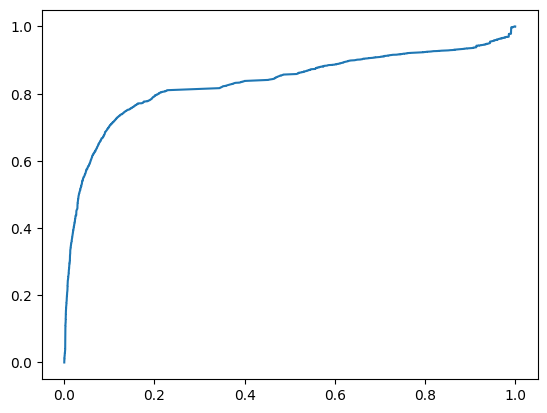

In [ ]:
plot_roc_curve(pos_score, neg_score)

In [ ]:
def add_children_to_graph(G: nx.DiGraph, e: helpers.EntryNode):
    for child in e.children:
        add_children_to_graph(G, child)
    
    G.add_node(
        e.id, 
        type=e.type.replace(":", ""), 
        desc=e.description
        )
        
    for child in e.children:
        G.add_edge(e.id, child.id)

def draw_syntax_tree(G: nx.DiGraph, width=None, heigth=None):
    type_labels = nx.get_node_attributes(G, "type")
    desc_labels = nx.get_node_attributes(G, "desc")

    pos = nx.nx_pydot.graphviz_layout(G, prog="dot")
    state_pos = {n: (x, y-8) for n, (x,y) in pos.items()}


    size = G.number_of_nodes() // np.ceil(np.power(G.number_of_nodes(), 0.25))
    width, heigth = size, size
    plt.figure(figsize=(width, heigth), dpi=100)
    # prop = mfm.FontProperties(fname=font_path)
    nx.draw_networkx(G, pos, labels=type_labels, node_size=1000, font_size=9)
    nx.draw_networkx_labels(G, state_pos, labels=desc_labels, font_color='red', font_size=9)

def change_nodes_encoding(G: nx.DiGraph):
    """
    Replaces Unicode symbols with "?", because Networkx does not work with Unicode symbols found in Agda.
    """
    for node in G.nodes:
        data = G.nodes[node]
        data["type"] = data["type"].encode("ascii", "replace").decode("utf-8")
        data["desc"] = data["desc"].encode("ascii", "replace").decode("utf-8")

def draw_syntax_tree_of_entry(entry: helpers.Entry):
    G = nx.DiGraph()
    add_children_to_graph(G, entry.root)
    try:
        draw_syntax_tree(G)
    except UnicodeEncodeError:
        change_nodes_encoding(G)
        draw_syntax_tree(G)

Entry:  NODE ID	NODE TYPE	NODE DESCRIPTION	CHILDREN IDS
137	:entry		[138, 139, 140]
138	:name	Agda.Builtin.Char.Char 6	[]
139	:type		[141, 142]
141	:sort		[143]
143	:sort-set		[145]
145	:max	1	[]
142	:sort		[144]
144	:sort		[146]
146	:sort-set		[147]
147	:max	0	[]
140	:axiom		[] 
Name:  Agda.Builtin.Char.Char 6 
Root:  
	Id:  137 
	Type:  :entry 
	Description:   
	Parents:  [] 
	Children:  [EntryNode(138, :name, Agda.Builtin.Char.Char 6), EntryNode(139, :type, ), EntryNode(140, :axiom, )] 

Corresponding network node:  {'label': ':axiom', 'encoded label': [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'embedding': [0.7475551564336315, 0.6247500691645237, 0.11124341729310216, 0.46633442630227606, 0.04201022680923405, 0.22965650072093025, 0.44298979723931586, 0.6069287437506778, 0.1383148684661809, 0.6984214225774078, 0.3578450087434607, 0.6477659190033203, 0.8771372152065301, 0.3288256471691624, 0.3517187966741593, 0.29930701557890504, 0.7103062306681192, 0.31122236517278

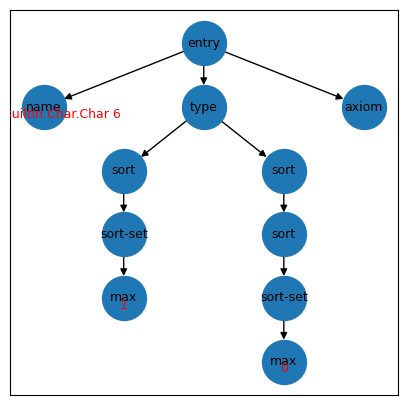

In [ ]:
e = entries[4] # 42
print(
    "Entry: ", e,
    "\nName: ", e.name,
    "\nRoot: ",
    "\n\tId: ", e.root.id,
    "\n\tType: ", e.root.type,
    "\n\tDescription: ", e.root.description,
    "\n\tParents: ", e.root.parents,
    "\n\tChildren: ", e.root.children,
    "\n\nCorresponding network node: ", network.nodes[e.name],
)

draw_syntax_tree_of_entry(e)

In [ ]:
types_counter = {}

def process_entry_node_for_type(entry: helpers.EntryNode):
    for child in entry.children:
        process_entry_node_for_type(child)
    entry_type = entry.type
    if entry_type in types_counter:
        types_counter[entry_type] += 1
    else:
        types_counter[entry_type] = 1

for entry in entries:
    process_entry_node_for_type(entry.root)

types_counter

{':name': 956753,
 ':max': 482463,
 ':sort-set': 389352,
 ':sort': 474487,
 ':type': 436858,
 ':data': 122,
 ':entry': 16483,
 ':apply': 707183,
 ':constructor': 12092,
 ':hidden': 814936,
 ':user-written': 1906989,
 ':level': 89106,
 ':arg': 1956390,
 ':not-hidden': 1138259,
 ':var': 1858884,
 ':anonymous': 25240,
 ':pi': 125820,
 ':bound': 333775,
 ':primitive': 114,
 ':axiom': 73,
 ':sort-setω': 49347,
 ':plus': 514345,
 ':record': 502,
 ':pattern-var': 109549,
 ':arg-noname': 38502,
 ':pattern': 20631,
 ':telescope': 20631,
 ':body': 19928,
 ':clause': 20631,
 ':function': 14881,
 ':interval-arg': 3515,
 ':lambda': 105078,
 ':sort-interval': 2861,
 ':sort-sset': 4004,
 ':constr': 120185,
 ':arg-name': 102145,
 ':proj': 93960,
 ':inserted': 143268,
 ':dot': 15192,
 ':no-body': 703,
 ':interval-apply': 2,
 ':sort-fun': 910,
 ':def': 4491,
 ':literal': 3798,
 ':no-type': 322,
 ':sort-size': 14,
 ':sort-prop': 1,
 ':instance': 3195,
 ':irrelevant': 1}

In [ ]:
len(types_counter)

49